In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# clone repo
# !git clone https://github.com/mahmoodlab/HIPT.git

In [3]:
import sys

sys.path.append("./HIPT/HIPT_4K/")

import torch
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(ImageFile.LOAD_TRUNCATED_IMAGES)
from torchinfo import summary
import seaborn as sns
from einops import rearrange, repeat
from HIPT.HIPT_4K.hipt_4k import HIPT_4K
from HIPT.HIPT_4K.hipt_model_utils import eval_transforms
import torchvision.transforms as T
from torchvision.models import resnet50, convnext_base, convnext_large, efficientnet_v2_s, efficientnet_v2_m
from torchvision.models import ResNet50_Weights, ConvNeXt_Large_Weights, ConvNeXt_Base_Weights, EfficientNet_V2_S_Weights, EfficientNet_V2_M_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.transforms.functional import pad
from hipt_model_utils import (
    get_vit256,
    get_vit4k,
    tensorbatch2im,
    eval_transforms,
    roll_batch2img,
)
import vision_transformer as vit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from functools import partial

from utils.utils import *
from utils.vit_utils import *
from utils.cross_val import *

True


/opt/conda/envs/hipt/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/hipt/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in t

## Check untransformed data

In [4]:
train_set, train_loader, test_set, test_loader = check_data()

In [5]:
small_region = Image.open("./HIPT/HIPT_4K/image_demo/image_256.png")
# small_region

In [6]:
min_dims = []
for img in test_set.orig_images:
    min_dims.append(min(img.size))

max_dims = []
for img in test_set.orig_images:
    max_dims.append(max(img.size))


In [7]:
# plt.hist(min_dims, bins=100)

In [8]:
# test_set.images[10]

## Define model

In [9]:
model = vit.vit_small(patch_size=16, num_classes=0)

# feature_extractor.eval();
checkpoint_key = "teacher"
pretrained_weights = "./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth"
device = torch.device("cuda:0")
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print(
        "Pretrained weights found at {} and loaded with msg: {}".format(
            pretrained_weights, msg
        )
    )
feature_extractor = model

Take key teacher in provided checkpoint dict
Pretrained weights found at ./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [10]:
# example = train_set[0][0]
# batch = example.unsqueeze(0)
# patches, num_patches = extract_patches(batch, size=224)

# for patch in patches:
#     plt.imshow(patch.cpu().numpy().transpose(1, 2, 0))
#     plt.show()

In [11]:

# # load different pretrained model
# # weights = ConvNeXt_Large_Weights.DEFAULT
# # model = convnext_large(weights=weights)

# # weights = ConvNeXt_Base_Weights.DEFAULT
# # model = convnext_base(weights=weights)

# weights = EfficientNet_V2_S_Weights.DEFAULT
# model = efficientnet_v2_s(weights=weights)
# return_nodes = {
#     "flatten": "out",
#     # "classifier.0": "out"
# }
# train_nodes, eval_nodes = get_graph_node_names(model)
# train_nodes[-10::]

# # return_nodes = ["classifier.1"]
# feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
# feature_extractor = FeatureExtractor(feature_extractor)

# device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# # device = "cpu"
# print(f"Using device: {device}")
# feature_extractor.to(device);
# feature_extractor.eval();
# model_transforms = weights.transforms(antialias=True)

In [12]:
with torch.no_grad():
    for batch in train_loader:
        img, label = batch
        img = img.to(device)
        patches, num_patches = extract_patches(img, size=224)
        out = feature_extractor(patches)
        out = out.reshape(-1, num_patches * out.shape[-1])

out.shape

torch.Size([62, 4608])

## Setup data

In [13]:
data_dir = "./data"
image_dir = f"{data_dir}/oxml-carinoma-classification"
image_paths, label_path = get_image_and_label_paths(image_dir)

labels_df = pd.read_csv(label_path)
labels = labels_df["malignant"].tolist()
train_ids = labels_df["id"].tolist()
train_set_paths, test_set_paths = get_train_test_paths(image_paths, train_ids=train_ids)
len(train_set_paths), len(test_set_paths)

(62, 124)

In [14]:
data_dir = "./data"
image_dir = f"{data_dir}/breakhis_v1"
image_paths_extra, label_path = get_image_and_label_paths(image_dir)

labels_df_extra = pd.read_csv(label_path)
labels_extra = labels_df_extra["malignant"].tolist()

In [15]:
len(image_paths_extra)

492

In [16]:
labels_df_extra

,file_name,cancer_type,subtype,magnification,malignant
0,SOB_M_DC-14-20629-100-026.png,malignant,ductal_carcinoma,100,1
1,SOB_M_DC-14-20629-100-010.png,malignant,ductal_carcinoma,100,1
2,SOB_M_DC-14-20629-200-004.png,malignant,ductal_carcinoma,200,1
3,SOB_M_DC-14-20629-200-009.png,malignant,ductal_carcinoma,200,1
4,SOB_M_DC-14-20629-400-010.png,malignant,ductal_carcinoma,400,1
...,...,...,...,...,...
487,SOB_B_A-14-29960CD-100-001.png,benign,adenosis,100,0
488,SOB_B_A-14-29960CD-200-010.png,benign,adenosis,200,0
489,SOB_B_A-14-29960CD-200-014.png,benign,adenosis,200,0
490,SOB_B_A-14-29960CD-400-003.png,benign,adenosis,400,0


Index([1, 0], dtype='int64', name='malignant')
Index(['malignant', 'benign'], dtype='object', name='malignant')


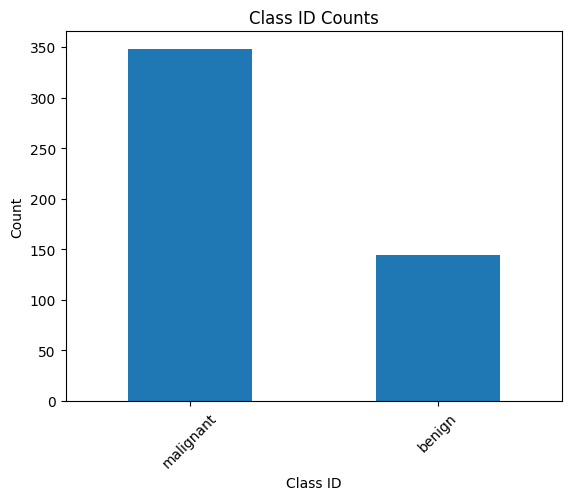

In [17]:
labels_df = pd.read_csv(label_path)
analyze_class_distribution(labels_df)

In [18]:
seed_everything(42)

In [19]:
test_transforms = T.Compose([eval_transforms()])
train_transforms = T.Compose([eval_transforms()])
train_set, train_loader, test_set, test_loader = prepare_train_test_data(
    train_set_paths,
    test_set_paths,
    labels,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    train_batch_size=62,
    test_batch_size=1024,
    num_workers=8,
    one_hot=False,
)

In [20]:
test_transforms = T.Compose([eval_transforms()])
train_transforms = T.Compose(
    [
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
        T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        eval_transforms(),
    ]
)
num_mod_samples_orig = len(train_set_paths + image_paths_extra)
(
    train_set_mod,
    train_loader_mod,
    test_set_mod,
    test_loader_mod,
) = prepare_train_test_data(
    train_set_paths + image_paths_extra,
    test_set_paths,
    labels + labels_extra,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    train_batch_size=128,
    test_batch_size=1024,
    num_workers=0,
    one_hot=False,
)

In [21]:
# k = 0
# for batch in itertools.cycle(train_loader_mod):
#     img, label = batch
#     print(img.shape)
#     print(label.shape)
#     k += 1
#     if k > 5:
#         break

## Extract features

In [22]:
patch_size = 224
X_train, y_train = extract_feature_sets(
    feature_extractor, train_loader, device=device, patch_size=patch_size
)
X_test, y_test = extract_feature_sets(
    feature_extractor, test_loader, device=device, patch_size=patch_size
)
X_train_mod, y_train_mod = extract_feature_sets(
    feature_extractor,
    train_loader_mod,
    num_samples_target=num_mod_samples_orig * 1,
    device=device,
    patch_size=patch_size,
)

X.shape: (62, 4608), y.shape: (62,)
X.shape: (124, 4608), y.shape: (124,)
X.shape: (554, 4608), y.shape: (554,)


In [ ]:
visualize_umap(X_train, y_train)

## Run Classifier

In [23]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline

In [36]:
# classifier = GaussianProcessClassifier(1.0 * RBF(1.0))
classifier = SVC(gamma="scale", C=2, class_weight="balanced")
# classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

# Create the pipeline
pipeline = make_pipeline(StandardScaler(), classifier)

In [37]:
classifier = cross_validate(
    pipeline,
    X_train,
    y_train,
    X_train_mod,
    y_train_mod,
    num_mod_samples_orig,
    splits=5,
)

Fold 0:
(98, 4608) (98,)
Train F1 micro: 1.0
Test F1 micro: 0.46153846153846156
Fold 1:
(98, 4608) (98,)
Train F1 micro: 1.0
Test F1 micro: 0.46153846153846156
Fold 2:
(100, 4608) (100,)
Train F1 micro: 1.0
Test F1 micro: 0.5833333333333334
Fold 3:
(100, 4608) (100,)
Train F1 micro: 1.0
Test F1 micro: 0.5
Fold 4:
(100, 4608) (100,)
Train F1 micro: 1.0
Test F1 micro: 0.5833333333333334
Average train F1 micro: 1.0
Average test F1 micro: 0.517948717948718


In [38]:
X_train_full = np.concatenate([X_train, X_train_mod])
y_train_full = np.concatenate([y_train, y_train_mod])
classifier.fit(X_train_full, y_train_full)
y_test_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)
f1_micro_train = f1_score(y_train, y_train_pred, average="micro")
print(f"f1_micro_train: {f1_micro_train}")

f1_micro_train: 0.967741935483871


In [ ]:
# y_train_pred, y_test_pred = run_sklearn_classifier(pipeline, X_train, y_train, X_test)

In [39]:
y_train_pred

array([-1, -1,  1, -1, -1,  0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  0, -1,
        0, -1,  1, -1,  1,  1,  0, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  0,  0,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1,  1, -1, -1, -1,  0, -1, -1])

## Save submission

Index([-1, 0, 1], dtype='int64', name='malignant')
Index(['negative', 'benign', 'malignant'], dtype='object', name='malignant')


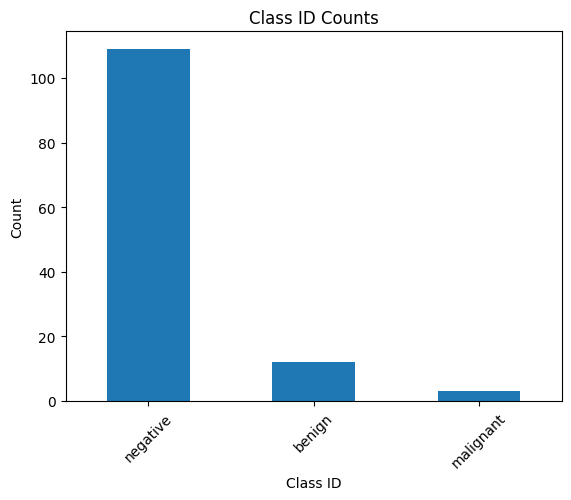

In [27]:
submission = create_submission_file(test_set_paths, y_test_pred)